In [1]:
import log_reg
import convnet
from imp import reload

from collections import defaultdict
import csv

import numpy as np
import pandas as pd

import evaluation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

%pylab --no-import-all inline
import matplotlib.pyplot as plt
%pylab inline

IndentationError: expected an indented block (convnet.py, line 51)

In [2]:
Y = 10
vocab_min = 3

In [48]:
v_dict = defaultdict(str)
c_dict = defaultdict(str)
with open('../mimicdata/vocab_lookup_' + str(vocab_min) + '.csv', 'r') as vocabfile:
    vr = csv.reader(vocabfile)
    next(vr)
    for row in vr:
        v_dict[int(row[0])] = row[1]

with open('../mimicdata/label_lookup_' + str(Y) + '.csv', 'r') as labelfile:
    lr = csv.reader(labelfile)
    next(lr)
    for row in lr:
        c_dict[int(row[0])] = row[1]

In [61]:
c_dict

defaultdict(str,
            {0: '5849',
             1: '4280',
             2: '4019',
             3: '25000',
             4: '41401',
             5: '2724',
             6: '5990',
             7: '42731',
             8: '53081',
             9: '51881'})

In [58]:
def y_to_codes(y_row):
    return [c_dict[i] for i in range(Y) if y_row[i] == 1]

In [59]:
def x_to_bow(x_row):
    return {v_dict[i]: x_row[i] for i in range(len(x_row)) if x_row[i] > 0}

In [17]:
reload(log_reg)
notefile = '../mimicdata/notes_' + str(Y) + '_train_final.csv'
X_tr, Y_tr = log_reg.construct_X_Y(notefile, Y)

Processing...................................................

In [19]:
X_tr.shape

(20108, 40000)

In [20]:
Y_tr.shape

(20108, 10)

In [21]:
X_tr[0].toarray().sum()

3597

In [23]:
devfile = '../mimicdata/notes_' + str(Y) + '_dev_final.csv'
X_dv, Y_dv = log_reg.construct_X_Y(devfile, Y)

Processing............................

In [24]:
X_dv.shape

(8972, 40000)

In [26]:
Y_dv.shape

(8972, 10)

In [27]:
yy_dev[-1]

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [28]:
testfile = '../mimicdata/notes_' + str(Y) + '_test_final.csv'
X_te, Y_te = log_reg.construct_X_Y(testfile, Y)

Processing.........................

In [29]:
X_te.shape

(8538, 40000)

In [30]:
Y_te.shape

(8538, 10)

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
def plot_metrics(ax, start, end, steps, y):
    x = np.linspace(start, end, steps)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        ax.plot(x, y)
    fig.canvas.draw()

## LogReg

***** C = 0.01 *****
5 iterations: 
acc,precision,recall,f1
0.339348652598 0.566106988939 0.404008989166 0.434568720525
10 iterations: 
acc,precision,recall,f1
0.351650107212 0.570289135865 0.42473988741 0.448312617684
15 iterations: 
acc,precision,recall,f1
0.358292023155 0.569594647192 0.436450969153 0.455360159729
20 iterations: 
acc,precision,recall,f1
0.357476390393 0.565021557367 0.43765710252 0.45399498765
25 iterations: 
acc,precision,recall,f1
0.360090696629 0.564089424594 0.443807453878 0.457465556067
***** C = 0.1 *****
5 iterations: 
acc,precision,recall,f1
0.339085576644 0.566496826104 0.403445198112 0.434241800331
10 iterations: 
acc,precision,recall,f1
0.34908184369 0.566204337657 0.420322175162 0.444429215952
15 iterations: 
acc,precision,recall,f1
0.352811701661 0.563619443914 0.429530364308 0.449031841988
20 iterations: 
acc,precision,recall,f1
0.357835797791 0.563596356212 0.439924075961 0.454850954143
25 iterations: 
acc,precision,recall,f1
0.356945594407 0.56382457

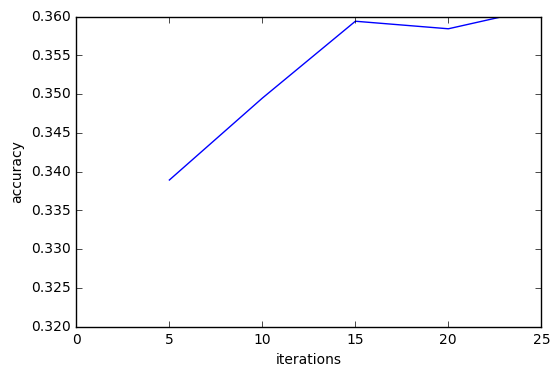

In [120]:
#grid search hyperparams of LR
reload(evaluation)
iter_step = 5
num_steps = 5
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
accs = {C:[] for C in Cs}
precisions = {C:[] for C in Cs}
recalls = {C:[] for C in Cs}
f1s = {C:[] for C in Cs}

fig,ax = plt.subplots(1,1)
ax.set_xlabel("iterations")
ax.set_ylabel("accuracy")
ax.set_xlim(0,iter_step*num_steps)

for C in Cs:
    print("***** C = " + str(C) + " *****")
    for i in range(num_steps):
        print(str((i+1)*iter_step) + " iterations: ")
        reg = OneVsRestClassifier(LogisticRegression(C=C,max_iter=iter_step*(i+1)))
        reg.fit(X_tr, Y_tr)
        yhat = reg.predict(X_dv)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, Y_dv)
        
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        
        accs[C].append(acc)
        precisions[C].append(precision)
        recalls[C].append(recall)
        f1s[C].append(f1)
        
        plot_metrics(ax, iter_step, (i+1)*iter_step, i+1, accs[C])

ValueError: x and y must have same first dimension

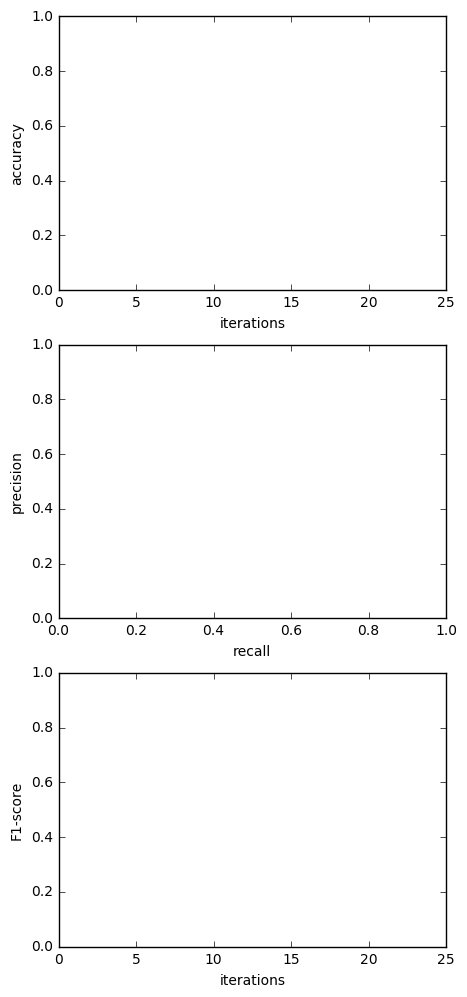

In [121]:
its = np.linspace(5,50,10)

fig,ax = plt.subplots(3,1)
fig.set_size_inches(5,12)
ax[0].set_xlabel("iterations")
ax[1].set_xlabel("recall")
ax[2].set_xlabel("iterations")
ax[0].set_ylabel("accuracy")
ax[1].set_ylabel("precision")
ax[2].set_ylabel("F1-score")
ax[0].set_xlim(0,iter_step*num_steps)
# ax[1].set_xlim(0,1)
ax[2].set_xlim(0,iter_step*num_steps)

for C in Cs:
    ax[0].plot(its,accs[C], '*', label="C=" + str(C))
    ax[1].plot(recalls[C], precisions[C], '*', label="C=" + str(C))
    ax[2].plot(its, f1s[C], '*', label="C=" + str(C))
ax[0].legend(loc=4)

In [140]:
mean_accs = [np.array(accs[C]).mean() for C in Cs]
mean_accs

[0.35093336960397348,
 0.3511319923442307,
 0.35104055754326852,
 0.35119138807945915,
 0.35099443030504202,
 0.35149700920905386]

In [151]:
mean_f1s = [np.array(f1s[C]).mean() for C in Cs]
np.array(f1s[1000]).mean()

0.45920534988256778

In [ ]:
#high number of iterations
reload(evaluation)
iter_step = 10
num_steps = 50
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
accs = {C:[] for C in Cs}
precisions = {C:[] for C in Cs}
recalls = {C:[] for C in Cs}
f1s = {C:[] for C in Cs}

fig,ax = plt.subplots(1,1)
ax.set_xlabel("iterations")
ax.set_ylabel("accuracy")
ax.set_xlim(0,iter_step*num_steps)

for C in Cs:
    print("***** C = " + str(C) + " *****")
    for i in range(num_steps):
        print(str((i+1)*iter_step) + " iterations: ")
        reg = OneVsRestClassifier(LogisticRegression(C=C,solver='sag', max_iter=iter_step*(i+1)))
        reg.fit(X_tr, yy_tr)
        yhat = reg.predict(X_dv)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, yy_dev)
        
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        
        accs[C].append(acc)
        precisions[C].append(precision)
        recalls[C].append(recall)
        f1s[C].append(f1)
        
#         plot_metrics(ax, iter_step, (i+1)*iter_step, i+1, accs[C])

***** C = 0.01 *****
10 iterations: 
acc,precision,recall,f1
0.330089006512 0.565409540613 0.43115822196 0.432490865128
20 iterations: 


In [115]:
#run for a long time
lr_long = OneVsRestClassifier(LogisticRegression(C=10.0, max_iter=10))
lr_long.fit(X_tr, Y_tr)
yhat = lr_long.predict(X_dv)
acc, precision, recall, f1 = evaluation.all_metrics(yhat, Y_dv)

print("acc,precision,recall,f1")
print(acc,precision,recall,f1)

acc,precision,recall,f1
0.348730574486 0.565874210064 0.419754801534 0.44408796113


In [116]:
yhat_tr = lr_long.predict(X_tr)

In [118]:
acc,precision,recall,f1 = evaluation.all_metrics(yhat_tr, Y_tr)
print("acc,precision,recall,f1")
print(acc,precision,recall,f1)

acc,precision,recall,f1
0.412691821308 0.618253514356 0.460854362632 0.496629684331


In [102]:
x_to_bow(X_tr[-1].toarray()[0])

{'intravenous': 1,
 'opacities': 6,
 'connected': 1,
 'pedal': 1,
 'rhythm': 1,
 'keep': 1,
 'related': 2,
 'social': 9,
 'dsds': 3,
 'sigmoid': 2,
 'want': 1,
 'head': 3,
 'activity': 6,
 'regular': 1,
 'short': 2,
 'appear': 4,
 'eat': 3,
 'hilar': 1,
 'discussed': 2,
 'c': 13,
 'break': 1,
 'dr': 5,
 'thin': 1,
 'quadrant': 2,
 'oriented': 5,
 'level': 3,
 'iv': 18,
 'dehisence': 1,
 'x4': 2,
 'cl': 1,
 'ca': 2,
 'secondary': 3,
 'chips': 2,
 'bladder': 2,
 'basal': 1,
 'carina': 1,
 'pads': 1,
 'site': 5,
 'using': 6,
 'port': 1,
 'midsternal': 1,
 'aorta': 2,
 'predominantly': 1,
 'draining': 5,
 'wean': 8,
 'hydralizine': 1,
 'wires': 11,
 'amout': 1,
 'however': 4,
 'extends': 1,
 'took': 1,
 'cont': 13,
 'qrs': 1,
 'costophrenic': 3,
 'contrast': 27,
 'mg': 2,
 'previously': 1,
 'breathing': 2,
 'svo2': 17,
 'involving': 2,
 'turned': 1,
 'pericolic': 2,
 'endotracheal': 1,
 'congestive': 1,
 'tinged': 2,
 'able': 2,
 'q3h': 1,
 'endocarditis': 21,
 'anxiety': 5,
 'periods': 1,

In [104]:
yhat[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [106]:
y_to_codes(yhat[-1])

['51881']

In [90]:
i = 0
for yh in yhat:
    if i < 100:
        print(y_to_codes(yh))
    i += 1

[]
['4280']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['51881']
[]
['4280']
[]
[]
[]
[]
[]
['4280', '51881']
[]
['4280']
[]
[]
[]
[]
[]
[]
['4280']
[]
[]
['4280']
[]
[]
[]
['5849', '4280']
[]
[]
[]
[]
[]
['4280']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['5849', '4280']
[]
[]
['4019']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['51881']
[]
[]
[]
[]
['4280', '51881']
[]
[]
['5849', '4280', '2724', '5990', '53081', '51881']
['5849', '4280', '51881']
[]
[]
[]
[]
[]
['4019']
[]
[]
[]
['4019']
[]
[]
[]
[]


## SVM

In [32]:
from sklearn.svm import SVC
iters = [3, 5, 7, 10]
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
svms = []
for mx_iter in iters:
    for C in Cs:
        print("C = " + str(C) + ", iters = " + str(mx_iter) + ": ")
        svm = OneVsRestClassifier(SVC(C=C, max_iter=mx_iter))
        svm.fit(X_tr, yy_tr)
        yhat = svm.predict(X_dv)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, yy_dev)
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        svms.append(svm)

C = 0.01, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 0.1, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 1.0, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 10.0, iters = 3: 
acc,precision,recall,f1
0.206748285854 0.25461677097 0.589105693056 0.310577218286
C = 100.0, iters = 3: 
acc,precision,recall,f1
0.0880359140816 0.112800923364 0.242436137033 0.13221510305
C = 1000.0, iters = 3: 
acc,precision,recall,f1
0.122095172521 0.189635203423 0.24662826487 0.181343287494
C = 0.01, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 0.1, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 1.0, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 10.0, iters = 5: 
acc,precision,recall,f1
0.2034

KeyboardInterrupt: 

In [18]:
pcts = sorted([np.array(yy_dev[i]).mean() for i in range(Y)])
pcts
#these are the % of instances containing this label for each of the top 10 labels

[0.18409501678285567,
 0.18874257681383941,
 0.2101729925122644,
 0.24141492383165505,
 0.26452362509682414,
 0.2747224373870385,
 0.3187451587916344,
 0.31900335657113349,
 0.32726568551510454,
 0.55499612703330747]

In [20]:
accs = [(yhat_tr == yy[i]).mean() for i in range(Y)]
accs

[0.77956364575264647,
 0.65085205267234703,
 0.45339530080041313,
 0.63665117479989675,
 0.77285050348566997,
 0.88187451587916343,
 0.81493674154402274,
 0.67867286341337463,
 0.86586625355021951,
 0.78563129357087524]

## ConvNet

In [7]:
import convnet

Using TensorFlow backend.


In [114]:
(X_tr_c, Y_tr_c), (X_dv_c, Y_dv_c) = convnet.load_data(Y)

In [115]:
reload(convnet)
model = convnet.build_model(Y)

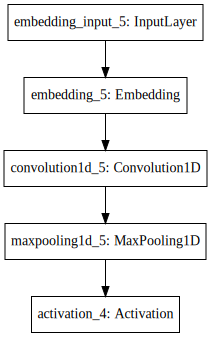

In [116]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [117]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, None, 50)      2000000     embedding_input_5[0][0]          
____________________________________________________________________________________________________
convolution1d_5 (Convolution1D)  (None, None, 10)      1510        embedding_5[0][0]                
____________________________________________________________________________________________________
maxpooling1d_5 (MaxPooling1D)    (None, None, 10)      0           convolution1d_5[0][0]            
____________________________________________________________________________________________________
activation_4 (Activation)        (None, None, 10)      0           maxpooling1d_5[0][0]             
Total params: 2,001,510
Trainable params: 2,001,510
Non-trainable params: 0
_______________

In [108]:
X_tr_c = np.reshape(X_tr_c, (1,20107))
Y_tr_c = np.reshape(Y_tr_c, (20107,1, 10))

In [118]:
X_tr_c.shape

(20107,)

In [119]:
Y_tr_c.shape

(20107, 10)

In [122]:
for note, label in zip(X_tr_c, Y_tr_c):
    print(len(note))
    print(len(label))
    model.train_on_batch(note, np.array([label]))
# model.fit(X_tr_c, Y_tr_c, batch_size=1, nb_epoch=5, validation_data=(X_dv_c, Y_dv_c))

267
10


ValueError: Error when checking model target: expected activation_4 to have 3 dimensions, but got array with shape (1, 10)